In [ ]:
# Let's start by retrieving some Magic card images using the Scryfall API
# https://scryfall.com/docs/api
# We'll be using the Scryfall python library
# https://github.com/NandaScott/Scrython

In [169]:
%load_ext autoreload
import requests
from requests.exceptions import TooManyRedirects, ReadTimeout, ConnectionError
import json
import pprint
import time
import shutil
import os
import os.path
import glob
import csv
from PIL import Image
import random
import numpy as np
import errno
import mxnet as mx
import csv
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

URL='https://api.scryfall.com'
OUTDIR='/Users/agussman/Documents/DeepLens/deeplens-magiccards/data'
#OUTDIR='/Users/aarongussman/Documents/Personal/deeplens-magiccards/data'
FOREGROUNDS_DIR = os.path.join(OUTDIR, "foregrounds")
BACKGROUNDS_DIR = os.path.join(OUTDIR, "backgrounds")
# foregrounds and backgrounds directores will be in OUTDIR
RUN="test03"
WORKING_DIR = os.path.join(OUTDIR, RUN)

random.seed()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Download Cards

In [5]:
# Get a list of sets
r = requests.get('https://api.scryfall.com/sets')
sets = r.json()['data']
print(sets[:2])
print(f"Number of sets: {len(sets)}")

[{'object': 'set', 'code': 'puma', 'name': 'Ultimate Box Topper', 'uri': 'https://api.scryfall.com/sets/puma', 'scryfall_uri': 'https://scryfall.com/sets/puma', 'search_uri': 'https://api.scryfall.com/cards/search?order=set&q=e%3Apuma&unique=prints', 'set_type': 'masterpiece', 'card_count': 40, 'parent_set_code': 'uma', 'digital': False, 'foil_only': True, 'icon_svg_uri': 'https://img.scryfall.com/sets/uma.svg?1541394000'}, {'object': 'set', 'code': 'uma', 'name': 'Ultimate Masters', 'uri': 'https://api.scryfall.com/sets/uma', 'scryfall_uri': 'https://scryfall.com/sets/uma', 'search_uri': 'https://api.scryfall.com/cards/search?order=set&q=e%3Auma&unique=prints', 'released_at': '2018-12-07', 'set_type': 'masters', 'card_count': 41, 'digital': False, 'foil_only': False, 'icon_svg_uri': 'https://img.scryfall.com/sets/uma.svg?1541394000'}]
Number of sets: 520


In [15]:
def download_card_images(results, odir, limit=99999):
    for result in results[:limit]:
        #card = result
        #if 'all_parts' in result
        #print(result['image_uris']['png'])
        time.sleep(0.25)
        try:
            image_url = result['image_uris']['png']
        except KeyError:
            # KeyError: 'image_uris'
            continue
        try:
            filename = "{}_{num:03d}.png".format(result['set'], num=int(result['collector_number']))
        except ValueError:
            # ValueError: invalid literal for int() with base 10: 'T1'
            filename = "{}_{}.png".format(result['set'], result['collector_number'])

        filename = os.path.join(odir, filename)
        #print(filename)
        #print("{} -> {}".format(image_url, filename))

        r = requests.get(image_url, stream=True)

        with open(filename, 'wb') as fd:
            for chunk in r.iter_content(chunk_size=128):
                fd.write(chunk)
    
    '''
    if r.status_code == 200:
        with open(os.path.join(OUTDIR, result['set'], filename), 'wb') as out_file:
            shutil.copyfileobj(response.raw(), out_file)
    else:
        print("Nope. {}".format(response.status_code))
    '''
    
    
#pprint.pprint(results[0:2])

In [17]:
# Limit it to "real" sets?
set_types_to_keep = [
    "core",
    "expansion",
    "masters",
    "masterpiece",
    "commander"
]

real_sets = [aset for aset in sets if aset["set_type"] in set_types_to_keep]

print(f"Number of \"real\" sets: {len(real_sets)}")

Number of "real" sets: 132


In [18]:
for aset in real_sets[:10]:
    print(aset['name'])
    print(aset['search_uri'])
    #r = requests.get('https://api.scryfall.com/cards/search?order=set&q=e:dom')
    r = requests.get(aset['search_uri'])
    
    odir = os.path.join(FOREGROUNDS_DIR, aset['code'])
    if not os.path.exists(odir):
        os.makedirs(odir)
    
    download_card_images(r.json()['data'], odir, 999)
    
    while ("next_page" in r.json()):
        print(r.json()['next_page'])
        r = requests.get(r.json()['next_page'])
        download_card_images(r.json()['data'], odir, 999)
    
    
# TODO: Support Scryfall pagination: https://scryfall.com/docs/api/lists

Ultimate Box Topper
https://api.scryfall.com/cards/search?order=set&q=e%3Apuma&unique=prints
Ultimate Masters
https://api.scryfall.com/cards/search?order=set&q=e%3Auma&unique=prints
Guilds of Ravnica
https://api.scryfall.com/cards/search?order=set&q=e%3Agrn&unique=prints
https://api.scryfall.com/cards/search?format=json&include_extras=false&order=set&page=2&q=e%3Agrn&unique=prints
Mythic Edition
https://api.scryfall.com/cards/search?order=set&q=e%3Amed&unique=prints
Commander 2018
https://api.scryfall.com/cards/search?order=set&q=e%3Ac18&unique=prints
https://api.scryfall.com/cards/search?format=json&include_extras=false&order=set&page=2&q=e%3Ac18&unique=prints
Core Set 2019
https://api.scryfall.com/cards/search?order=set&q=e%3Am19&unique=prints
https://api.scryfall.com/cards/search?format=json&include_extras=false&order=set&page=2&q=e%3Am19&unique=prints
Commander Anthology Volume II
https://api.scryfall.com/cards/search?order=set&q=e%3Acm2&unique=prints
https://api.scryfall.com/cards

# Download Backgrounds

In [25]:
# Next let's download some pictures of tables
# TODO: Don't download HTML as a JPG
table_list_url = 'http://image-net.org/api/text/imagenet.synset.geturls?wnid=n03201035'
r = requests.get(table_list_url)

file_urls = r.text.splitlines()

In [ ]:
for num, table_url in enumerate(file_urls):
    print(num, table_url)
    time.sleep(0.25)
    filename = "{num:003d}_{original}".format(num=num, original=os.path.basename(table_url))
    filename = os.path.join(BACKGROUNDS_DIR, 'tables', filename)
    #print(filename)
    print("{} -> {}".format(table_url, filename))
    
    try:
        r = requests.get(table_url, stream=True, timeout=1)
        if r.status_code == 200:
            print(r.headers['content-type'])
            if r.headers['content-type'].startswith("image"):
                print(r.url)
                if not r.url.endswith('photo_unavailable.png'):
                    with open(filename, 'wb') as fd:
                        for chunk in r.iter_content(chunk_size=128):
                            fd.write(chunk)
                else:
                    print("SKIP: photo_unavailable.png")
            else:
                print("SKIP: content header didn't start with image? {}".format(r.headers['content-type']))
        else:
            print("SKIP: Problem downloading: {}".format(r.status_code))
    except TooManyRedirects:
        print("SKIP: TooManyRedirects")
    except ReadTimeout:
        print("SKIP: ReadTimeout")
    except ConnectionError:
        print("SKIP: ConnectionError")
    


# Generate Synthetic Images

In [218]:
# Function to past an image on top of another image
# Returns bounding box and square perimiter for use in creating a .lst file
# Coordinates are in fraction of width or height
def compose_images(foreground_path, background_path):
    # Make sure the foreground path is valid and open the image
    assert os.path.exists(foreground_path), 'image path does not exist: {}'.format(foreground_path)
    assert os.path.splitext(foreground_path)[1].lower() == '.png', 'foreground must be a .png file'
    foreground = Image.open(foreground_path)
    foreground_alpha = np.array(foreground.getchannel(3))
    assert np.any(foreground_alpha == 0), 'foreground needs to have some transparency: {}'.format(foreground_path)
    
    # Make sure the background path is valid and open the image
    assert os.path.exists(background_path), 'image path does not exist: {}'.format(background_path)
    assert os.path.splitext(background_path)[1].lower() in ['.png', '.jpg', 'jpeg'], \
        'foreground must be a .png or .jpg file: {}'.format(foreground_path)
    background = Image.open(background_path)
    background = background.convert('RGBA')
    width, height = background.size
    assert width > 10, 'width is too small {}'.format(width)
    assert height > 10, 'height is too small {}'.format(height)
    
    # Rotate the foreground
    #fbbox = foreground.getbbox()
    #print(fbbox)
    #angle_degrees = random.randint(0, 359)
    angle_degrees = random.randint(0, 180) - 90
    # TODO: try
    # 1/4 of the time keep it close to center
    # 1/4 of the time keep it 90 to 180
    # 1/4 of the time -180 to 180
    # 1/4 of the time anywhere
    foreground = foreground.rotate(angle_degrees, resample=Image.BICUBIC, expand=True)
    
    # Scale the foreground
    max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    while (max_xy_position[0] < 0 or max_xy_position[1] < 0):
        #print("Scaling down...")
        scale = 1.0 / (random.random() * 23.0 + 1.0) # Pick something between 1 and 31
        new_size = (int(foreground.size[0] * scale), int(foreground.size[1] * scale))
        foreground = foreground.resize(new_size, resample=Image.BICUBIC)
        max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    
    
    # Add any other transformations here...
    
    # Choose a random x,y position for the foreground
    #max_xy_position = (background.size[0] - foreground.size[0], background.size[1] - foreground.size[1])
    assert max_xy_position[0] >= 0 and max_xy_position[1] >= 0, \
        'foreground {} is to big for the background {}'.format(foreground_path, background_path)
    paste_position = (random.randint(0, max_xy_position[0]), random.randint(0, max_xy_position[1]))
    
    # Create a new foreground image as large as the background and paste it on top
    new_foreground = Image.new('RGBA', background.size, color = (0, 0, 0, 0))
    new_foreground.paste(foreground, paste_position)
        
    # Extract the alpha channel from the foreground and paste it into a new image the size of the background
    alpha_mask = foreground.getchannel(3)
    new_alpha_mask = Image.new('L', background.size, color=0)
    new_alpha_mask.paste(alpha_mask, paste_position)
    composite = Image.composite(new_foreground, background, new_alpha_mask)
    
    # Grab the alpha pixels above a specified threshold
    alpha_threshold = 200
    mask_arr = np.array(np.greater(np.array(new_alpha_mask), alpha_threshold), dtype=np.uint8)
    hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L')
    
    # Get the smallest & largest non-zero values in each dimension and calculate the bounding box
    nz = np.nonzero(hard_mask)
    try:
        ymin, xmin, ymax, xmax = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])]
    except ValueError:
        print("Probably the zero-size array to reduction operation minimum which has no identity error")
        print(foreground_path)
        print(background_path)
    
    # I think there's a weird possibility of 0-length sides that breaks ImageDetIter
    if (ymin >= ymax):
        if (ymax < height):
            ymax += 1
        else:
            ymin -= 1
    if (xmin >= xmax):
        if (xmax < width):
            xmax += 1
        else:
            xmin -= 1
    
    # Converting everything to % scale because we can't have nice things
    bbox = ymin / height, xmin / width, ymax / height, xmax / width
    
    # Get the respective x and y coordinates associated with the points where the card
    # touches the bounding box
    
    # smallest x associated w/ smallest y
    # Again, converting to %'s
    if ( angle_degrees >= 270 and angle_degrees <= 359):
        ymin_x = min(nz[1][nz[0] == ymin])
        xmax_y = min(nz[0][nz[1] == xmax])
        ymax_x = max(nz[1][nz[0] == ymax])
        xmin_y = max(nz[0][nz[1] == xmin])
    
    else:
        ymin_x = min(nz[1][nz[0] == ymin])
        xmax_y = max(nz[0][nz[1] == xmax])
        ymax_x = max(nz[1][nz[0] == ymax])
        xmin_y = min(nz[0][nz[1] == xmin])

                 
    pdim = [
        [ymin_x / width, ymin / height],
        [xmax / width, xmax_y / height],
        [ymax_x / width, ymax / height],
        [xmin / width, xmin_y / height]
    ]

    
    #print(pdim)
    
    #print(f"Lens of nz things: {len(nz[0])} and {len(nz[1])}")
    #print(f"nz things: {nz}")
    #print(f"bbox: {bbox}")
    return composite, hard_mask, bbox, pdim

In [229]:
# Test generating a synthetic image
foreground_path = os.path.join(FOREGROUNDS_DIR, 'm19', 'm19_001.png')
#background_path = os.path.join(BACKGROUNDS_DIR, 'tables', '988_332335994_1086af4c67.jpg')
background_path = os.path.join(BACKGROUNDS_DIR, 'tables', '982_688045410_371d396906.jpg')

composite, mask, bbox, pdim = compose_images(foreground_path, background_path)
bbox

(0.2853333333333333, 0.598, 0.552, 0.854)

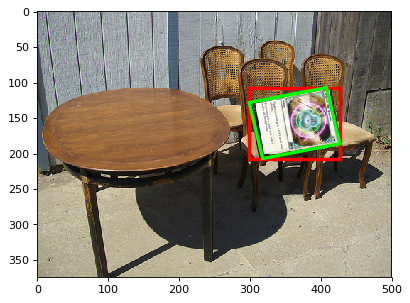

In [230]:
# Plot the synthetic image
dpi = 80
margin = 0.05 # (5% of the width/height of the figure...)
#xpixels, ypixels = 800, 800

width, height = composite.size

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
figsize = (1 + margin) * height / dpi, (1 + margin) * width / dpi

fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

ax.imshow(composite, interpolation='none')
ymin , xmin, ymax, xmax = bbox
ymin = ymin * height
xmin = xmin * width
ymax = ymax * height
xmax = xmax * width

rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
ax.add_patch(rect)

plot_pdim = [[i[0] * width, i[1] * height] for i in pdim]
poly = Polygon(plot_pdim, True, fill=False, edgecolor=(0, 1, 0), linewidth=3)
ax.add_patch(poly)
plt.show()

In [187]:
# Generate a bunch of synthetic images
# Following https://www.immersivelimit.com/tutorials/composing-images-with-python-for-synthetic-datasets
# sometimes this throws a 'composite not defined' error?
def generate_synthetic_images(n_images, out_dir, foregrounds, backgrounds):
    # Create a list to keep track of images and mask annotations
    csv_lines = []

    # Generate n new images
    for i in range(n_images):
        #print(f"RUN {i}")
        foreground_path = random.choice(foregrounds)
        background_path = random.choice(backgrounds)
        try:
            composite, mask, bbox, pdim = compose_images(foreground_path, background_path)
            
            composite_path = os.path.join(output_dir, 'image_{0:04d}.png'.format(i))
            composite.save(composite_path)
            #print(f"foreground_path: {foreground_path}\nbackground_path: {background_path}\ncomposite_path: {composite_path}")

            #mask_path = os.path.join(output_dir, 'mask_{0:04d}.png'.format(i))
            #mask.save(mask_path)

            width, height = composite.size
            csv_lines.append([width, height, bbox, pdim, composite_path])
        except OSError:
            print(f"OSError???? Probably something isn't an image and probably it's the background. {foreground_path} {background_path}")
            next

    return csv_lines

In [84]:
# Output the annotations csv
# Using file layout from here: https://mxnet.incubator.apache.org/versions/master/api/python/image/image.html
# id header_width object_width object_id, xmin, ymin, xmax, ymax image_path
def write_annotations_lst(annotations_csv_path, csv_lines):
    with open(annotations_csv_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter='\t', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for idx, csv_line in enumerate(csv_lines):
            width, height, bbox, pdim, image_path = csv_line
            #outrow = [idx, 4, 5, width, height, idx, bbox[0] / height, bbox[1] / width, bbox[2] / height, bbox[3] / width, image_path]
            outrow = [
                idx,
                4, # width of header (2 + length of extra header), so, everything to the first object excluding idx
                13, # width of each object (DOES NOT INCLUDE PATH)
                width,
                height,
                idx,
            ] + [ i for i in bbox] + [kk for k in pdim for kk in k] + [ image_path ]
                #] + [ i for i in bbox] + [100, image_path ]
                # ImageDetIter tries to convert everything to a float and will
                # throw a ValueError unless we unroll these 
                # bbox,
                # pdim,

            writer.writerow(outrow)

In [236]:
# Set variables for data output
output_dir = os.path.join(WORKING_DIR, 'generated')
test_dir = os.path.join(WORKING_DIR, 'test')

foregrounds = glob.glob(FOREGROUNDS_DIR+"/*/*.png")
backgrounds = glob.glob(BACKGROUNDS_DIR+"/*/*.jpg")

train_lst_path = os.path.join(WORKING_DIR, 'train.lst')
test_lst_path = os.path.join(WORKING_DIR, 'test.lst')

# num_training_samples is reused when we attempt to fit a model
num_training_samples = 200
num_test_samples = 200

# When creating an Image Iterator (eg, ImageDetIterator) from the output .lst, you'll need to set:
batch_size = 32 # Number of examples per batch, some examples are 4, pikachu uses 32
data_shape = 300 # Data shape in (channels, height, width) format. For now, only RGB image with 3 channels is supported.
                 # some example had 224, but pikachu example uses 256
                 # I think this is the same parameter as image_shape in the object detector hyperparameters and so
                 # I'm going with 300 which is the min 

In [237]:
# Generate training data
%time train_csv = generate_synthetic_images(num_training_samples, output_dir, foregrounds, backgrounds)
write_annotations_lst(train_lst_path, train_csv)

CPU times: user 1min 14s, sys: 1.1 s, total: 1min 15s
Wall time: 1min 16s


In [232]:
# Generate test data
%time test_csv = generate_synthetic_images(num_test_samples, test_dir, foregrounds, backgrounds)
write_annotations_lst(test_lst_path, test_csv)

CPU times: user 1min 9s, sys: 757 ms, total: 1min 10s
Wall time: 1min 10s


In [238]:
# Reload the contents of the .lst file into an Image Iterator
# Note that there are a suite of transformations/manipulations you can perform on the image to alter it
# as part of this process
data_iter = mx.image.ImageDetIter(batch_size=batch_size, data_shape=(3, data_shape, data_shape),
                                      path_imglist=train_lst_path, path_root='/')

204 176


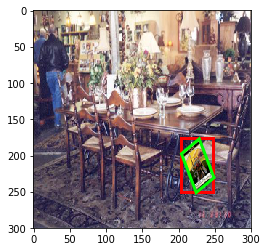

175 15


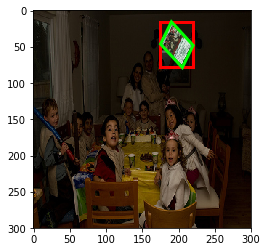

250 204


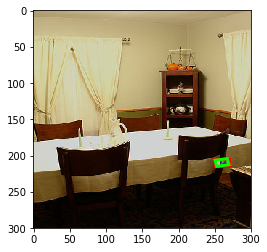

173 36


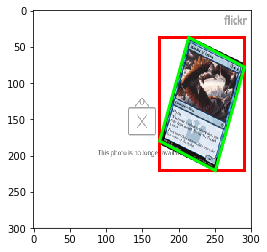

23 21


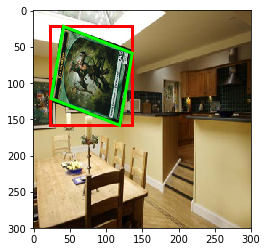

25 166


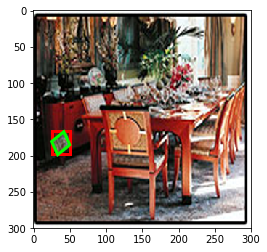

168 91


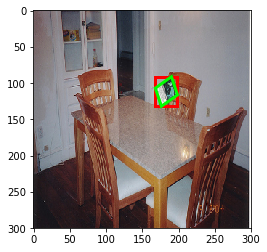

112 189


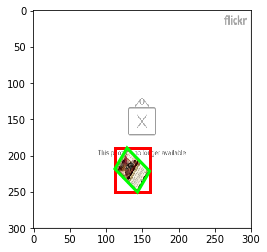

117 71


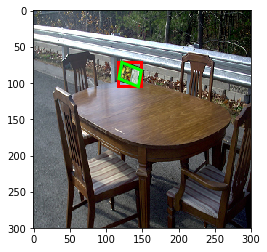

120 28


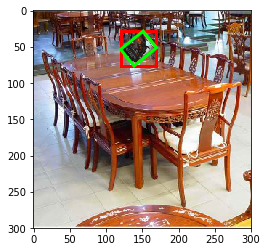

In [239]:
# https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html
data_iter.reset()
batch = data_iter.next()
#print(batch)
#data_shape = 500

for i in range(0,10):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    img = batch.data[0][i].asnumpy()  # grab the first image, convert to numpy array
    img = img.transpose((1, 2, 0))  # we want channel to be the last dimension
    #img += np.array([123, 117, 104])
    img = img.astype(np.uint8)  # use uint8 (0-255)

    ax.imshow(img, interpolation='none')
    #axs[i].imshow(img, interpolation='none')

    # TODO: How to get image dimension?
    #width, height = img.size

    # draw bounding boxes on image
    for label in batch.label[0][i].asnumpy():
        if label[0] < 0:
            print("MISSING LABEL???? (maybe you set i out of range)")
            break
        #print(label)
        ymin, xmin, ymax, xmax = [int(x * data_shape) for x in label[1:5]]


        print(xmin, ymin)
        #ymin, xmin, ymax, xmax = [x * data_shape for x in label[1:5]]
        #xmin = xmin * width
        #xmax = xmax * width
        #ymin = ymin * height
        #ymax = ymax * height
        #xmin, ymin, xmax, ymax = label[1:5]
        # scale to new size
        #xmin, ymin, xmax, ymax = 58, 179, 150, 279
        #xmin, ymin, xmax, ymax = label[, 179, 150, 279

        # TODO: Pickup with this (need to scale height/width)
        #xmin = xmin * data_shape
        #ymin = ymin * data_shape
        #xmax = xmax * data_shape
        #ymax = ymax * data_shape
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor=(1, 0, 0), linewidth=3)
        ax.add_patch(rect)

        stuffs = iter([i for i in label[5:]])
        plot_pdim = [[i * data_shape, next(stuffs) * data_shape] for i in stuffs]
        poly = Polygon(plot_pdim, True, fill=False, edgecolor=(0, 1, 0), linewidth=3)
        ax.add_patch(poly)

        plt.show()

Here's how you can run im2rec.py
(note that this code is super important in order to do anything and it has instructions, no help functionaly, and no documents in the code)

`$ python /Users/agussman/.virtualenvs/deeplens-magiccards/lib/python3.6/site-packages/mxnet/tools/im2rec.py --pack-label --num-thread 2 data/train.lst /`

Got instructions from:
 * https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco/object_detection_recordio_format.ipynb
 * https://mxnet.incubator.apache.org/faq/recordio.html

In [240]:
!python /Users/agussman/.virtualenvs/deeplens-magiccards/lib/python3.6/site-packages/mxnet/tools/im2rec.py --pack-label --num-thread 2 {train_lst_path} /
!python /Users/agussman/.virtualenvs/deeplens-magiccards/lib/python3.6/site-packages/mxnet/tools/im2rec.py --pack-label --num-thread 2 {test_lst_path} /

Creating .rec file from /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/test03/train.lst in /Users/agussman/Documents/DeepLens/deeplens-magiccards/data/test03
libpng warning: iCCP: known incorrect sRGB profile
time: 0.026900053024291992  count: 0
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known

## Upload to S3

In [241]:
%autoreload 1
%aimport sagemaker
from sagemaker import get_execution_role
sess = sagemaker.Session()

# role = get_execution_role()
# running this outside of a Sagemaker notebook
# I created this role by going through the IAM New Role wizard
role = 'sagemaker-wizard'

# When you create an S3 bucket, you should probably put 'sagemaker' in the name, so that 
# the role you created will automatically be able to access is
bucket = "deeplens-magiccards"
#prefix = "train_002"
prefix = RUN

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'

In [242]:
from  sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:latest


In [243]:
# Upload the RecordIO files to train and validation channels

# These objects will need to be tagged with SageMaker = true
# You should be able to do this programatically with https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/s3.html#S3.Client.put_object_tagging
sess.upload_data(path=train_lst_path.replace('.lst', '.rec'), bucket=bucket, key_prefix=train_channel)
sess.upload_data(path=test_lst_path.replace('.lst', '.rec'), bucket=bucket, key_prefix=validation_channel)

's3://deeplens-magiccards/test03/validation/test.rec'

## Training

In [244]:
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

print(s3_train_data)
print(s3_validation_data)
print(s3_output_location)

s3://deeplens-magiccards/test03/train
s3://deeplens-magiccards/test03/validation
s3://deeplens-magiccards/test03/output


In [245]:
# Needed to request a resource limit increase to use an ml.p2 instance type
# You should specify that you want to use them for Sagemaker training
# It will probably take you a couple tries to get them to increase the limit.

# Docs: https://sagemaker.readthedocs.io/en/latest/estimators.html

# According to this you should use Pipe instead of File input_mode: 
# https://aws.amazon.com/blogs/machine-learning/using-pipe-input-mode-for-amazon-sagemaker-algorithms/
# FWIW, I can't actually get "Pipe" to work, after launch of training it
# throws ValidationError and explicitly says it only knows File
# That being said, check the size of your data. My .rec is only 125MB, so 
# I can't see it giving that much of a speedup anyway
od_model  = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1,                                         
                                         #train_instance_type='ml.p3.2xlarge',
                                         train_instance_type='ml.p2.xlarge',
                                         #train_instance_type='local_gpu',
                                         train_volume_size = 30, # EBS volume. This can be small if you're using Pipe input_mode
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [246]:
# MAKE SURE YOU SET data_shape! Should match what you had when creating ImageDetIter()

# Turns out a lot of these settings matter
# https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-api-config.html
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=0,
                             num_classes=1,       # MATTERS
                             mini_batch_size=32,
                             epochs=10,         # MATTERS
                             learning_rate=0.001,
                             lr_scheduler_step='3,6',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=data_shape, # MATTERS
                             label_width=350, # MATTERS
                             num_training_samples=num_training_samples # MATTERS
                            )

In [247]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='application/x-recordio', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-recordio', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': validation_data}

In [248]:
# When you launch this, pay attention to the line like:
# INFO:sagemaker:Creating training-job with name: object-detection-2018-09-01-02-39-10-022
# You'll need the training-job name when you go to deploy to DeepLens
%time od_model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: object-detection-2018-11-13-04-50-24-136


2018-11-13 04:50:34 Starting - Starting the training job..
Launching requested ML instances..
Preparing the instances for training.......
2018-11-13 04:53:10 Downloading - Downloading input data
2018-11-13 04:53:23 Training - Downloading the training image..
Docker entrypoint called with argument(s): train
[11/13/2018 04:53:56 INFO 140289614337856] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_objective_metric': u'', u'early_stopping_tolerance': u'0.0', u'learning_rate': u'0.0

/Users/agussman/.virtualenvs/deeplens-magiccards/lib/python3.6/site-packages/sagemaker/session.py:875: DeprecationWarning: generator 'multi_stream_iter' raised StopIteration
  for idx, event in sagemaker.logs.multi_stream_iter(client, log_group, stream_names, positions):


[11/13/2018 04:54:34 INFO 140289614337856] #quality_metric: host=algo-1, epoch=0, batch=6 train cross_entropy <loss>=(2.25488703823)
[11/13/2018 04:54:34 INFO 140289614337856] #quality_metric: host=algo-1, epoch=0, batch=6 train smooth_l1 <loss>=(1.12993885754)
[11/13/2018 04:54:34 INFO 140289614337856] Round of batches complete
[11/13/2018 04:54:34 INFO 140289614337856] Updated the metrics
[11/13/2018 04:54:38 INFO 140289614337856] #quality_metric: host=algo-1, epoch=0, validation mAP <score>=(0.0)
[11/13/2018 04:54:38 INFO 140289614337856] Updating the best model with validation-mAP=0.0
[11/13/2018 04:54:38 INFO 140289614337856] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[11/13/2018 04:54:38 INFO 140289614337856] #progress_metric: host=algo-1, completed 10 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Rec

[11/13/2018 04:55:45 INFO 140289614337856] #quality_metric: host=algo-1, epoch=6, batch=6 train cross_entropy <loss>=(0.599925321287)
[11/13/2018 04:55:45 INFO 140289614337856] #quality_metric: host=algo-1, epoch=6, batch=6 train smooth_l1 <loss>=(0.934168566455)
[11/13/2018 04:55:45 INFO 140289614337856] Round of batches complete
[11/13/2018 04:55:46 INFO 140289614337856] Updated the metrics
[11/13/2018 04:55:50 INFO 140289614337856] #quality_metric: host=algo-1, epoch=6, validation mAP <score>=(0.0)
[11/13/2018 04:55:50 INFO 140289614337856] Updating the best model with validation-mAP=0.0
[11/13/2018 04:55:50 INFO 140289614337856] Saved checkpoint to "/opt/ml/model/model_algo_1-0000.params"
[11/13/2018 04:55:50 INFO 140289614337856] #progress_metric: host=algo-1, completed 70 % of epochs
#metrics {"Metrics": {"Max Batches Seen Between Resets": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of Batches Since Last Reset": {"count": 1, "max": 0, "sum": 0.0, "min": 0}, "Number of R

In [249]:
print(od_model._current_job_name)
print(od_model.latest_training_job)
training_job = od_model.latest_training_job

object-detection-2018-11-13-04-50-24-136


## Hosting

In [ ]:
# If you've run od_model.fit() this session, you don't need to run attach()
# Run attach() to "load" a previously generated model. You provide it the training job name reported by fit.
# You can also retrieve it from https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/jobs
#training_job = "object-detection-2018-09-01-02-39-10-022"
#sess = sagemaker.Session()
#od_model.attach(training_job, sess)


In [250]:
print(od_model._current_job_name)

object-detection-2018-11-13-04-50-24-136


In [251]:
print(od_model.latest_training_job)

# Inference

In [254]:
#instance_type = 'ml.m4.xlarge'
%time object_detector = od_model.deploy(initial_instance_count = 1, instance_type = 'ml.t2.xlarge')

INFO:sagemaker:Creating model with name: object-detection-2018-11-13-05-08-49-408
INFO:sagemaker:Creating endpoint with name object-detection-2018-11-13-04-50-24-136


-------------------------------------------------------!CPU times: user 402 ms, sys: 45.8 ms, total: 447 ms
Wall time: 5min 29s


In [264]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

In [276]:
file_name = '/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1493.png'
#file_name = '/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/generated/image_1495.png'
#file_name = '/Users/agussman/Documents/DeepLens/deeplens-magiccards/data/test03/generated/image_1976.png'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

In [277]:
object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b)
detections = json.loads(results)
#print (detections)

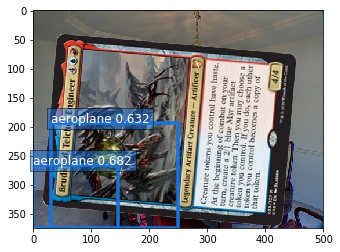

In [279]:
object_categories = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 
                     'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 
                     'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.6

# Visualize the detections.
#visualize_detection(file_name, detections['predictions'][0]['prediction'], object_categories, threshold)
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

In [280]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

INFO:sagemaker:Deleting endpoint with name: object-detection-2018-11-13-04-50-24-136


## DeepLens

In [ ]:
# Next we import our custom model to DeepLens following the instructions here:
# https://docs.aws.amazon.com/deeplens/latest/dg/deeplens-import-from-sagemaker.html
# followed by:
# https://docs.aws.amazon.com/deeplens/latest/dg/deeplens-create-custom-project.html
# Note the line above like:
# INFO:sagemaker:Creating training-job with name: object-detection-2018-09-01-02-39-10-022

In [ ]:
data_iter.reset()
batch = data_iter.next()
data = batch.data[0]
#for i in range(4):
#    plt.subplot(1,4,i+1)
#    plt.imshow(data[i].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.imshow(data[1].asnumpy().astype(np.uint8).transpose((1,2,0)))
plt.show()

In [ ]:
# Working forward from https://gluon.mxnet.io/chapter08_computer-vision/object-detection.html

In [ ]:
import mxnet as mx
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))

y = MultiBoxPrior(x, sizes=[.5, .25, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[20, 20, 0, :])

In [ ]:
import matplotlib.pyplot as plt
def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]),
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [ ]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Class prediction', cls_pred(x).shape)

In [ ]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Box prediction', box_pred(x).shape)

In [ ]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
print('Before', x.shape, 'after', blk(x).shape)

In [ ]:
# a certain feature map with 20x20 spatial shape
feat1 = nd.zeros((2, 8, 20, 20))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

In [ ]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

In [ ]:
# TODO This needs to be made something actual?
# from the text: Common choices follow the architectures of the state-of-the-art convolution neural 
# networks for image classification. For demonstration purpose, we just stack several down sampling 
# blocks to form the body network.
from mxnet import gluon
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((2, 3, 256, 256))
print('Body network', [y.shape for y in bnet(x)])

In [ ]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))

    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))

    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, 2))

In [ ]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):
    # extract feature with the body network
    x = body(x)

    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale
    default_anchors = []
    predicted_boxes = []
    predicted_classes = []

    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [ ]:
from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)

    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))

        return anchors, class_preds, box_preds

In [ ]:
# instantiate a ToySSD network with 10 classes
net = ToySSD(2)
net.initialize()
x = nd.zeros((1, 3, 256, 256))
default_anchors, class_predictions, box_predictions = net(x)
print('Outputs:', 'anchors', default_anchors.shape, 'class prediction', class_predictions.shape, 'box prediction', box_predictions.shape)


In [ ]:
class_names = ['magic_card']
num_class = len(class_names)
train_data = data_iter

In [ ]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [ ]:
from mxnet import gluon
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)


In [ ]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

In [ ]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()  # measure absolute difference between prediction and target

In [ ]:
from mxnet import nd
### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
try:
    _ = nd.zeros(1, ctx=ctx)
    # pad label for cuda implementation
    train_data.reshape(label_shape=(3, 5))
    train_data = test_data.sync_label_shape(train_data)
except mx.base.MXNetError as err:
    print('No GPU enabled, fall back to CPU, sit back and be patient...')
    ctx = mx.cpu()

# This reports no GPU...
# Looks like I'd need to follow instructions here to get it to work:
# https://mxnet.incubator.apache.org/install/index.html

In [ ]:
net = ToySSD(num_class)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)

In [ ]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [ ]:
# DID YOU SET train_data above?
#epochs = 150  # set larger to get better performance
epochs = 50
log_interval = 20
from_scratch = True  # set to True to train from scratch
if from_scratch:
    start_epoch = 0
else:
    start_epoch = 148
    pretrained = 'ssd_pretrained.params'
    sha1 = 'fbb7d872d76355fff1790d864c2238decdb452bc'
    url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/models/ssd_pikachu-fbb7d872.params'
    if not osp.exists(pretrained) or not verified(pretrained, sha1):
        print('Downloading', pretrained, url)
        download(url, fname=pretrained, overwrite=True)
    net.load_params(pretrained, ctx)

In [ ]:
import time
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx)
            y = batch.label[0].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f'
                  %(epoch ,i, batch_size/(time.time()-btic), name1, val1, name2, val2))

    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))

print('{} training images, {} epochs (%f)'.format(n_generated_images, epochs, time.time()-tic))    
# we can save the trained parameters to disk
net.save_params('ssd_%d.params' % epochs)

In [ ]:
# Test
import numpy as np
import cv2
def preprocess(image):
    """Takes an image and apply preprocess"""
    # resize to data_shape
    image = cv2.resize(image, (data_shape, data_shape))
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= np.array([123, 117, 104])
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image
i = 0
image = cv2.imread(os.path.join(test_dir, 'image_{0:04d}.png'.format(i)))
x = preprocess(image)
print('x', x.shape)

In [ ]:
# if pre-trained model is provided, we can load it
# net.load_params('ssd_%d.params' % epochs, ctx)
anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

In [ ]:
from mxnet.contrib.ndarray import MultiBoxDetection
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output)

In [ ]:
def display(img, out, thresh=0.5):
    import random
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False,
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = class_names[cid]
        plt.gca().text(xmin, ymin-2, '{:s} {:.3f}'.format(text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()

thresh = 0.45
#thresh = 0.55
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=thresh)

## Export the model to SageMaker

We're following the instructions from [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/mxnet_mnist_byom/mxnet_mnist.ipynb) starting with **Set up hosting for the model**

In [ ]:
# TODO: THis? https://mxnet.incubator.apache.org/tutorials/gluon/save_load_params.html

import os
import json
#os.mkdir('model')

savedir = 'data/model'

#net.save_checkpoint(savedir + '/model', 0000)
#with open ( savedir + '/model-shapes.json', "w") as shapes:
#    json.dump([{"shape": net.data_shapes[0][1], "name": "data"}], shapes)

net.export(savedir, epochs)

import tarfile
def flatten(tarinfo):
    tarinfo.name = os.path.basename(tarinfo.name)
    return tarinfo

tar = tarfile.open("data/model.tar.gz", "w:gz")
tar.add(savedir, filter=flatten)
tar.close()


In [41]:
aa = 102
bb = 256

zz = aa / bb
zz

0.3984375

In [46]:
a, b, c = [1, 44, 77]
x = [a, b, c]
x
y = (1, 4, 9)
y
z = [[133, 8], [369, 165], [261, 328], [25, 171]]
z

[[133, 8], [369, 165], [261, 328], [25, 171]]

In [47]:
h = 10
w = 100
z2 = [[i[0] / w, i[1] / h] for i in z]
z2

[[1.33, 0.8], [3.69, 16.5], [2.61, 32.8], [0.25, 17.1]]

In [82]:
[7, 8] + [i for i in x] + [j for j in y]

[7, 8, 1, 44, 77, 1, 4, 9]

In [88]:
[kk for k in z for kk in k]

[133, 8, 369, 165, 261, 328, 25, 171]

In [44]:
N = 3
np.random.rand(N, 2)

array([[0.20767573, 0.37706861],
       [0.8428173 , 0.43861981],
       [0.78541588, 0.48331643]])

In [ ]:
import time

query = input("Type the name of the set: ")

time.sleep(0.05)
sets = scrython.sets.Sets()

for i in range(sets.data_length()):
    if sets.set_name(i) == query:
        print("Set code:", sets.set_code(i).upper())
        break
    else:
        continue

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x115aaec18>)

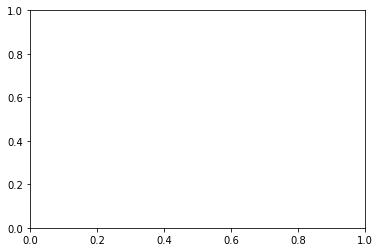

In [134]:
x = plt.subplots(1)
x

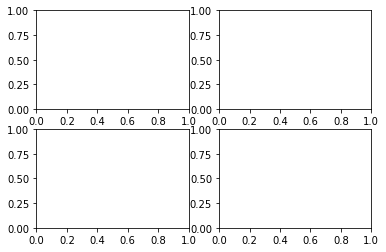

In [142]:
f, axes = plt.subplots(2,2)

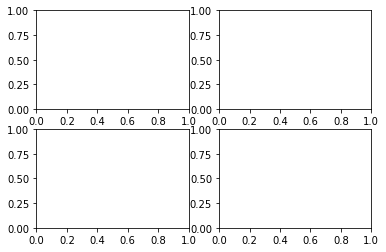

In [146]:
f

In [149]:
len(axs[0])


2

In [150]:
axs[0]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x116ef9080>,
      dtype=object)

In [153]:
for x in range(0,2):
    print(x)

0
1


In [167]:
x = 97
!echo {x}

97
